# NAMED ENTITY RECOGNITION

In [1]:
# execute this once to get the data set
# !mkdir -p data!
# !wget https://data.deepai.org/conll2003.zip -P data/
# !unzip data/conll2003.zip -d data/

# Libraries to Import

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision
from sklearn.metrics import precision_score, recall_score

# Importing Data

In [3]:
def read_and_process(file_path):
    # Reading data as text
    with open(file_path) as f:
        text = f.read().split("\n")[2:]
        
    # Storing Input sentences and their respective tags in X and y variables 
    X = []
    y = []
    X_seq = []
    y_seq = []
    lens = []
    for e in text:
        if e == "":
            X.append(X_seq)
            y.append(y_seq)
            lens.append(len(X_seq))
            X_seq = []
            y_seq = []
        else:
            w = e.split()
            assert len(w) == 4
            X_seq.append(w[0])  # token
            y_seq.append(w[3])  # NER
            
    #some statistics about respective data
    print("Number of sentences:", len(X))
    ner_tags = set([item for sublist in y for item in sublist])
    print("Number of NER taggings:", len(ner_tags))
    print("NER tags:", ner_tags)
    #Calculating percentiles to understand the distribution of the sentence lengths 
    print("Quantiles of the sentence lengths:", np.quantile(lens, q=[0.25, 0.5, 0.75, 1]))
    print("Number of Input sentences:", len(X))
    print("Number of Label sentences:", len(y))
    return X, y

In [4]:
train_file = 'data/conll2003/train.txt'
X,y=read_and_process(train_file)

Number of sentences: 14987
Number of NER taggings: 9
NER tags: {'B-LOC', 'B-MISC', 'I-LOC', 'I-PER', 'O', 'B-ORG', 'B-PER', 'I-ORG', 'I-MISC'}
Quantiles of the sentence lengths: [  5.   9.  21. 113.]
Number of Input sentences: 14987
Number of Label sentences: 14987


In [5]:
val_file='data/conll2003/valid.txt'
X_val,y_val=read_and_process(val_file)

Number of sentences: 3466
Number of NER taggings: 9
NER tags: {'B-LOC', 'B-MISC', 'I-LOC', 'I-PER', 'O', 'B-ORG', 'B-PER', 'I-ORG', 'I-MISC'}
Quantiles of the sentence lengths: [  5.  10.  23. 109.]
Number of Input sentences: 3466
Number of Label sentences: 3466


# Conversion of Both Data into Pandas Data Frames

# Training DataFrame

In [6]:
# Converting the X and y into dataframe to do visualization and preprocessing 

def create_sentence_dataframe(X, y,j):
    sentences = {
        'Word': [],
        'SentenceID': [],
        'Length': [],
        'Tag': []
    }
    
    for i, sentence in enumerate(X):
        num_words = len(sentence)
        sentence_id = f"Sentence_{j}"
      
        sentences['Word'].extend(sentence)
        sentences['SentenceID'].extend([sentence_id] * num_words)
        sentences['Length'].extend([num_words] * num_words)
        sentences['Tag'].extend(y[i])
        j=j+1
    dataframe=pd.DataFrame(sentences)    
    return dataframe

In [7]:
df_train=create_sentence_dataframe(X,y,j=0)

In [8]:
df_train.shape

(204566, 4)

In [9]:
#Number of sentences in training data
df_train["SentenceID"].unique().shape

(14986,)

In [10]:
df_train.head(10)

,Word,SentenceID,Length,Tag
0,EU,Sentence_0,9,B-ORG
1,rejects,Sentence_0,9,O
2,German,Sentence_0,9,B-MISC
3,call,Sentence_0,9,O
4,to,Sentence_0,9,O
5,boycott,Sentence_0,9,O
6,British,Sentence_0,9,B-MISC
7,lamb,Sentence_0,9,O
8,.,Sentence_0,9,O
9,Peter,Sentence_1,2,B-PER


# Validation DataFrame

In [11]:
# number of unique sentence IDs in the training data.
j=df_train["SentenceID"].unique().shape[0]

df_val=create_sentence_dataframe(X_val, y_val,j)
df_val.shape

(51577, 4)

In [12]:
df_val["SentenceID"].unique().shape

(3465,)

In [13]:
df_val.head(10)

,Word,SentenceID,Length,Tag
0,CRICKET,Sentence_14986,11,O
1,-,Sentence_14986,11,O
2,LEICESTERSHIRE,Sentence_14986,11,B-ORG
3,TAKE,Sentence_14986,11,O
4,OVER,Sentence_14986,11,O
5,AT,Sentence_14986,11,O
6,TOP,Sentence_14986,11,O
7,AFTER,Sentence_14986,11,O
8,INNINGS,Sentence_14986,11,O
9,VICTORY,Sentence_14986,11,O


# Importing Test Data

In [14]:
test_file='data/conll2003/test.txt'
#Read and get some statistics about Test data
X_test,y_test=read_and_process(test_file)  
#sum of the number of unique sentence IDs in both the training and validation data
j=df_train["SentenceID"].unique().shape[0]+df_val["SentenceID"].unique().shape[0]
#convert into pandas data frame and get shape
df_test=create_sentence_dataframe(X_test, y_test,j)
df_test.shape

Number of sentences: 3684
Number of NER taggings: 9
NER tags: {'B-LOC', 'B-MISC', 'I-PER', 'O', 'B-ORG', 'B-PER', 'I-MISC', 'I-ORG', 'I-LOC'}
Quantiles of the sentence lengths: [  5.   8.  19. 124.]
Number of Input sentences: 3684
Number of Label sentences: 3684


(46665, 4)

In [15]:
# Test data contains 3683 unique sentences
df_test["SentenceID"].unique().shape 

(3683,)

In [16]:
df_test.head(10)

,Word,SentenceID,Length,Tag
0,SOCCER,Sentence_18451,12,O
1,-,Sentence_18451,12,O
2,JAPAN,Sentence_18451,12,B-LOC
3,GET,Sentence_18451,12,O
4,LUCKY,Sentence_18451,12,O
5,WIN,Sentence_18451,12,O
6,",",Sentence_18451,12,O
7,CHINA,Sentence_18451,12,B-PER
8,IN,Sentence_18451,12,O
9,SURPRISE,Sentence_18451,12,O


# Combining all Dataframes to perform id's mapping and data visualization

In [17]:
# Combining training, validation,test data into a single df
df = pd.concat([df_train, df_val,df_test], axis=0)
df.head(10)

,Word,SentenceID,Length,Tag
0,EU,Sentence_0,9,B-ORG
1,rejects,Sentence_0,9,O
2,German,Sentence_0,9,B-MISC
3,call,Sentence_0,9,O
4,to,Sentence_0,9,O
5,boycott,Sentence_0,9,O
6,British,Sentence_0,9,B-MISC
7,lamb,Sentence_0,9,O
8,.,Sentence_0,9,O
9,Peter,Sentence_1,2,B-PER


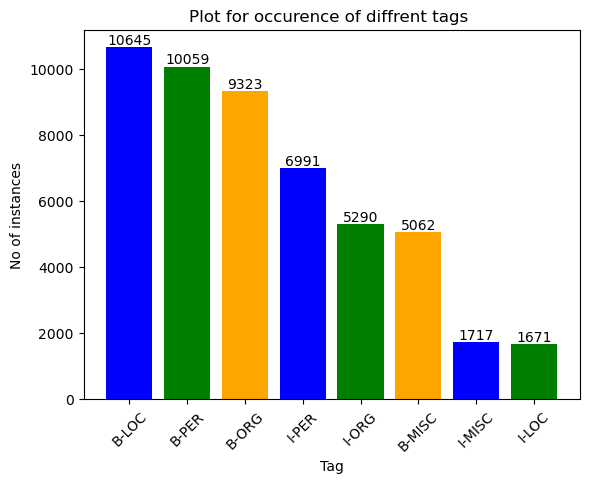

In [18]:
# Visualization of NER tags 
colors = ['blue', 'green', 'orange']
category_counts = df[df['Tag']!="O"]['Tag'].value_counts()
plt.bar(category_counts.index, category_counts.values,color=colors)

# Add the values on top of the bars
for i, v in enumerate(category_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.xlabel('Tag')
plt.ylabel('No of instances')
plt.title('Plot for occurence of diffrent tags ')
plt.xticks(rotation=45)
plt.show()

# Convert Words into integer-encoded sequences using Text Vectorization 

In [19]:
#the maximum length of the sentences in the training data
maxlength=df["Length"].max()

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=None,
    output_mode='int',
    output_sequence_length=int(maxlength),
    standardize=None)

In [20]:
# build the vocabulary based on unique words of all data
vectorize_layer.adapt(np.array(df['Word'])) 

In [21]:
#retrieve the vocabulary and its size from the vectorize_layer
vocabulary = vectorize_layer.get_vocabulary()
vocab_size = vectorize_layer.vocabulary_size()
print("Vocabulary size:", len(vocabulary))
print("Vocabulary excerpt:", vocabulary[:30])

Vocabulary size: 30292
Vocabulary excerpt: ['', '[UNK]', ',', '.', 'the', 'of', 'in', 'to', 'a', '(', ')', 'and', '"', 'on', 'said', "'s", 'for', '-', '1', 'The', 'was', '-DOCSTART-', 'at', '2', '3', '0', 'with', 'that', 'from', 'by']


In [22]:
## Our data was one word per row , now we are converting it into one sentence per row 
df_train = df_train.groupby('SentenceID',sort=False).agg({'Word': ' '.join, 'Tag': ' '.join}).reset_index()
df_val = df_val.groupby('SentenceID',sort=False).agg({'Word': ' '.join, 'Tag': ' '.join}).reset_index()
df_test = df_test.groupby('SentenceID',sort=False).agg({'Word': ' '.join, 'Tag': ' '.join}).reset_index()

In [23]:
df_train.head()

,SentenceID,Word,Tag
0,Sentence_0,EU rejects German call to boycott British lamb .,B-ORG O B-MISC O O O B-MISC O O
1,Sentence_1,Peter Blackburn,B-PER I-PER
2,Sentence_2,BRUSSELS 1996-08-22,B-LOC O
3,Sentence_3,The European Commission said on Thursday it di...,O B-ORG I-ORG O O O O O O B-MISC O O O O O B-M...
4,Sentence_4,Germany 's representative to the European Unio...,B-LOC O O O O B-ORG I-ORG O O O B-PER I-PER O ...


In [24]:
# Vectorizing i.e converting training , validation and testing word sequences into integer-encoded sequences
X_train = vectorize_layer(df_train['Word'])
X_val = vectorize_layer(df_val['Word'])
X_test = vectorize_layer(df_test['Word'])


In [25]:
#print to verify what could be the integer encoded sequence for first training sentence
print(df_train["Word"][0])
print("\nEncoded sequence: ", X_train[0])

EU rejects German call to boycott British lamb .

Encoded sequence:  tf.Tensor(
[ 1071 11140   241   840     7  4025   232  8775     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(124,), dtype=int64)


# Convert Tags into integer-encoded sequences using Text Vectorization 

In [26]:
# Building vectorizer for tags/target i.e to vectorize the tag sequences
vectorize_layer_tags = tf.keras.layers.TextVectorization(
    max_tokens=None,
    output_mode='int',
    output_sequence_length=int(maxlength),
    standardize=None)

In [27]:
#analyze the tag data and build its internal vocabulary based on the unique tags present in the data.
vectorize_layer_tags.adapt(np.array(df['Tag'])) 

vocabulary_tag = vectorize_layer_tags.get_vocabulary()
vocab_tag_size = vectorize_layer_tags.vocabulary_size()
print("Tags size:", len(vocabulary_tag))
print("Tags excerpt:", vocabulary_tag[:30])

Tags size: 11
Tags excerpt: ['', '[UNK]', 'O', 'B-LOC', 'B-PER', 'B-ORG', 'I-PER', 'I-ORG', 'B-MISC', 'I-MISC', 'I-LOC']


In [28]:
# Converting output tags into integer-encoded sequences 
y_train = vectorize_layer_tags(df_train['Tag'])
y_val = vectorize_layer_tags(df_val['Tag'])
y_test = vectorize_layer_tags(df_test['Tag'])

In [29]:
#print to verify what could be the integer encoded sequence for first training sentence
# Following sentence, each tag has a unique integer value like 0= 2, B-MISC=8
print("Original sentence: ",df_train["Word"][0] )
print("Tags sequence: ",df_train["Tag"][0])
print("\nEncoded sequence for tag: ", y_train[0])

Original sentence:  EU rejects German call to boycott British lamb .
Tags sequence:  B-ORG O B-MISC O O O B-MISC O O

Encoded sequence for tag:  tf.Tensor(
[5 2 8 2 2 2 8 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(124,), dtype=int64)


# Preparing Target Data

In [30]:
# one hot encoding of target tags so that model can learn and predict each Tag category independently
y_train = to_categorical(y_train.numpy(), num_classes=vocab_tag_size)
y_val = to_categorical(y_val.numpy(), num_classes=vocab_tag_size)
y_test = to_categorical(y_test.numpy(), num_classes=vocab_tag_size)

In [31]:
print(y_train[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [32]:
y_train.shape

(14986, 124, 11)

In [33]:
y_val.shape

(3465, 124, 11)

In [34]:
y_test.shape

(3683, 124, 11)

# Build an LSTM based Model with Prepared Data

In [35]:
num_classes=11
embedding_size = 150

model = Sequential()
# Embedding layer takes the input sequence of integers to convert it into a dense vector representation
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(units=60, return_sequences=True)))
# Adding a dropout layer to prevent overfitting
model.add(Dropout(0.2)) 
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
# To get output probabilities for each of the 11 classes.
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 124, 150)          4543800   
                                                                 
 bidirectional (Bidirectiona  (None, 124, 120)         101280    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 124, 120)          0         
                                                                 
 lstm_1 (LSTM)               (None, 124, 60)           43440     
                                                                 
 dropout_1 (Dropout)         (None, 124, 60)           0         
                                                                 
 dense (Dense)               (None, 124, 11)           671       
                                                        

In [36]:
# Compiling our model as it is multi-class, we will use categorical cross entropy as loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision()])

In [37]:
# Training our model upto 4 epochs and storing the training history 
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4)


Epoch 1/4
469/469 [==============================] - 178s 357ms/step - loss: 0.1448 - accuracy: 0.9714 - precision: 0.9820 - val_loss: 0.0763 - val_accuracy: 0.9799 - val_precision: 0.9844
Epoch 2/4
469/469 [==============================] - 159s 340ms/step - loss: 0.0425 - accuracy: 0.9869 - precision: 0.9966 - val_loss: 0.0326 - val_accuracy: 0.9907 - val_precision: 0.9963
Epoch 3/4
469/469 [==============================] - 171s 364ms/step - loss: 0.0161 - accuracy: 0.9954 - precision: 0.9983 - val_loss: 0.0255 - val_accuracy: 0.9937 - val_precision: 0.9952
Epoch 4/4
469/469 [==============================] - 170s 362ms/step - loss: 0.0068 - accuracy: 0.9984 - precision: 0.9989 - val_loss: 0.0242 - val_accuracy: 0.9941 - val_precision: 0.9949


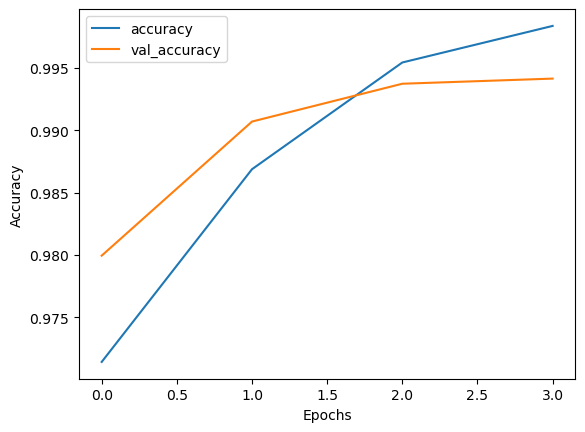

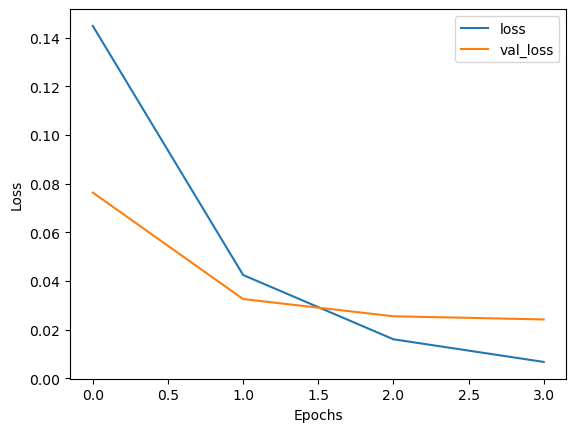

In [38]:
# Plotting the history which shows the progress of each epochs 
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["loss", "val_loss"])
plt.show()

# Model Evaluation on Test Data

In [39]:
#Evaluating model on test data
model.evaluate(X_test, y_test)

116/116 [==============================] - 12s 100ms/step - loss: 0.0289 - accuracy: 0.9925 - precision: 0.9937


[0.028936520218849182, 0.9925004243850708, 0.9936631917953491]

In [40]:
# model's output predictions for the test data
y_pred = model.predict(X_test)
#predicted and true labels for each timestep in the test sequence
y_pred_labels = np.argmax(y_pred, axis=2)
y_true_labels=np.argmax(y_test, axis=2)

116/116 [==============================] - 12s 86ms/step


In [41]:
#Precision and Recall for each class separately

precision = precision_score(y_true_labels.flatten(), y_pred_labels.flatten(), average=None)
recall = recall_score(y_true_labels.flatten(), y_pred_labels.flatten(), average=None)

In [42]:
# Display the precision for each class
for i in range(len(precision)):
    name = vocabulary_tag[i]
    print("Class {}: Precision = {:.2f}".format(name, precision[i]))

Class : Precision = 1.00
Class [UNK]: Precision = 0.96
Class O: Precision = 0.90
Class B-LOC: Precision = 0.92
Class B-PER: Precision = 0.68
Class B-ORG: Precision = 0.93
Class I-PER: Precision = 0.62
Class I-ORG: Precision = 0.69
Class B-MISC: Precision = 0.57
Class I-MISC: Precision = 0.42


In [43]:
# Display the Recall for each class
for i in range(len(recall)):
    name=vocabulary_tag[i]
    print("Class {}: Recall = {:.2f}".format(name, recall[i]))

Class : Recall = 1.00
Class [UNK]: Recall = 0.98
Class O: Recall = 0.79
Class B-LOC: Recall = 0.53
Class B-PER: Recall = 0.73
Class B-ORG: Recall = 0.56
Class I-PER: Recall = 0.80
Class I-ORG: Recall = 0.70
Class B-MISC: Recall = 0.61
Class I-MISC: Recall = 0.53


# Demonstration of Trained Model on a Test Sentence

In [50]:
sentence=df_test["Word"].iloc[100]
print(sentence)
example_input=vectorize_layer(sentence)
example_input = tf.reshape(example_input, shape=(1, -1,))
predicted_example=np.argmax(model.predict(example_input), axis=2)

one-day cricket international between Pakistan and New Zealand
1/1 [==============================] - 0s 69ms/step


In [51]:
#generate predicted tags for each word in the sentence and compare them to the corresponding tags in the DataFrame
length=len(df_test["Word"].iloc[100].split(" "))
predictedtagsexample=[vocabulary_tag[i] for i in predicted_example.flatten()]
print("Predicted Tags: ", predictedtagsexample[:length])
print("Original Tags ",df_test["Tag"].iloc[100])

Predicted Tags:  ['O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'I-LOC']
Original Tags  O O O O B-LOC O B-LOC I-LOC


# Predicting labels for a user-input sentence using trained model

In [54]:
sentence=input("Please enter a sentence: ")
print("\n Test sentence: ", sentence)
example_input=vectorize_layer(sentence)
example_input = tf.reshape(example_input, shape=(1, -1,))
predicted_example=np.argmax(model.predict(example_input), axis=2)
predicted_tags_example=[vocabulary_tag[i] for i in predicted_example.flatten()]
print("Predicted tags: ", predicted_tags_example[:])

Please enter a sentence: The United Nations General Assembly will convene in New York City.

 Test sentence:  The United Nations General Assembly will convene in New York City.
1/1 [==============================] - 0s 68ms/step
Predicted tags:  ['B-ORG', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


# Reference

[1]. Speech and Language Processing. Daniel Jurafsky & James H. Martin. Chapter 8 and 9. Draft of January 7, 2023. https://web.stanford.edu/~jurafsky/slp3/8.pdf

[2]. Introduction to the CoNLL-2003 Shared Task: Language-Independent Named Entity Recognition.Erik F. Tjong Kim Sang and Fien De Meulder. https://aclanthology.org/W03-0419.pdf